In [22]:
"""Verify the gradient derivation of linear masked autoencoder."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import numpy as np
import pandas as pd 
import scipy.stats as stats

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# set default to be float64
torch.set_default_dtype(torch.float64)

### Model initialisation

In [25]:
# Linear auto-encoder model
class LAE(nn.Module):
    def __init__(self, n, p):
        super(LAE, self).__init__()
        self.n = n
        self.p = p
        self.w1 = nn.Linear(n, p, bias=False)
        self.w2 = nn.Linear(p, n, bias=False)

    def forward(self, y):
        y = self.w1(y)
        y = self.w2(y)
        return y

In [26]:
## Masked lienar auto-encoder model
# Define different types of masks
def mask_basic(prob, sample_num, feature_num):
    return torch.zeros(sample_num, feature_num).bernoulli_(prob)

def mask_dropping_probs(prob_list: torch.Tensor, sample_num, feature_num):
    return torch.zeros(sample_num, feature_num).bernoulli_(prob_list)

def mask_patches(prob, patch_size: torch.Tensor, sample_num, sample_dim: torch.Tensor):
    feature_num = sample_dim[0]*sample_dim[1]
    div_check = sample_dim % patch_size == torch.zeros(2)
    if torch.all(div_check):
        pix_num = torch.div(sample_dim, patch_size, rounding_mode='floor')
        mat_patches = torch.zeros(sample_num, *pix_num).bernoulli_(prob)
        mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=2)
        return mat_patches.repeat_interleave(patch_size[0], dim=1).view(sample_num, feature_num)
    else:
        raise NotImplementedError(f"Both height ({sample_dim[0]}) and width ({sample_dim[1]}) should be divisible by patch_size ({patch_size}).")


# Masked autoencoder (linear)
class M_LAE(nn.Module):
    def __init__(self, prob, sample_dim, reduction_dim, type='basic', patch_size=None):
        super(M_LAE, self).__init__()
        self.prob = prob
        self.sample_dim = sample_dim
        self.H, self.W = sample_dim
        self.n = self.H * self.W
        self.p = reduction_dim
        if type not in ['basic', 'probs', 'patches']:
            raise NotImplementedError("Could only implement 'basic', 'probs' and 'patches' type of masking.")
        else:
            self.masking_type = type
        if patch_size is not None:
            self.patch_size = patch_size
        w1 = nn.Linear(self.n, self.p, bias=False)
        w2 = nn.Linear(self.p, self.n, bias=False)
        self.body = nn.Sequential(*[w1, w2])
    
    def forward(self, X, mask=None):
        m = X.shape[0]
        if mask is None:
            if self.masking_type == 'basic':
                mask = mask_basic(self.prob, m, self.n).to(device)
            elif self.masking_type == 'probs':
                mask = mask_dropping_probs(self.prob, m, self.n).to(device)
            elif self.masking_type == 'patches':
                mask = mask_patches(self.prob, self.patch_size, m, self.sample_dim).to(device)
        Y = mask * X
        Y = self.body(Y)
        return Y

In [27]:
class FE_Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(FE_Net, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.theta = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, W):
        return self.theta(W)

In [28]:
def train_loop(data_dict, model, criterion, optimizer, type, epochs=10, sample_average=10, record=True):
    train_loss = []
    val_loss = []
    if type=='encoder':
        train_inputs = data_dict['train_inputs']
        train_targets = train_inputs
    elif type=='fe':
        train_inputs = data_dict['train_inputs']
        train_targets = data_dict['train_targets']
        sample_average = 1

    for epoch in range(epochs+1):
        loss_total = 0
        optimizer.zero_grad()
        for i in range(sample_average):
            train_outputs = model(train_inputs)
            loss = criterion(train_outputs, train_targets)
            loss_total += loss
        loss_total /= sample_average
        loss_total.backward()
        optimizer.step()
        if record:
          train_loss.append(loss_total.item())
          if epochs>=5 and epoch%(epochs//5)==0:
              v_loss = test_loop(data_dict, model, criterion, type)
              val_loss.append(v_loss)
              print('epoch: ', epoch, ', train loss: ', loss.item(), ', val loss', v_loss)
    if record:
        return {'train_loss': train_loss, 'val_loss': val_loss}
    else:
        return loss_total.item()

def test_loop(data_dict, model, criterion, type):
    if type=='encoder':
        val_inputs = data_dict['val_inputs']
        val_targets = val_inputs
    elif type=='fe':
        val_inputs = data_dict['val_inputs']
        val_targets = data_dict['val_targets']

    with torch.no_grad():
        val_outputs = model(val_inputs)
        loss = criterion(val_outputs, val_targets)
    return loss.item()

In [29]:
# feature extraction
def feature_extraction(data_dict, model_parameters, criterion, type, epochs=200, device='cuda'):
    train_inputs, train_targets, val_inputs, val_targets = data_dict.values()

    params = list(model_parameters)
    W1 = params[0].clone().detach()
    train_inputs_fe = train_inputs @ W1.T
    val_inputs_fe = val_inputs @ W1.T
    reduction_dim = train_inputs_fe.shape[1]
    target_dim = train_targets.shape[1]

    if type=='ls':
        param_fe = (torch.inverse(train_inputs_fe.T@train_inputs_fe) @ train_inputs_fe.T @ train_targets).T
        loss = criterion(val_targets, val_inputs_fe @ param_fe.T)
        return loss.item()
    elif type=='gd':
        data_dict_fe = {'train_inputs': train_inputs_fe, 'train_targets': train_targets,
                        'val_inputs': val_inputs_fe, 'val_targets': val_targets}
        net_fe = FE_Net(reduction_dim, target_dim).to(device)
        param_fe = list(net_fe.parameters())
        optimizer = optim.Adam(param_fe, lr=0.0001)
        ### TRAINING ###
        loss_fe = train_loop(data_dict_fe, net_fe, criterion, optimizer, epochs=epochs, record=False, type='fe')
        return loss_fe

### Dataset

In [30]:
train_num = 60
val_num = 30
H = 12
W = 12
sample_dim = torch.tensor([H, W])
feature_num = H * W
reduction_dim = feature_num // 4
target_dim = feature_num // 2

prob = 0.75
prob_list = torch.rand(feature_num)*0.2 + 0.65
patch_size = torch.div(sample_dim, 4, rounding_mode='floor')

train_inputs = torch.rand(train_num, feature_num) * 2
train_inputs = train_inputs.to(device)
train_targets = torch.rand(train_num, target_dim)
train_targets = train_targets.to(device)
val_inputs = torch.rand(val_num, feature_num) * 2
val_inputs = val_inputs.to(device)
val_targets = torch.rand(val_num, target_dim)
val_targets = val_targets.to(device)
data_dict = {'train_inputs': train_inputs, 'train_targets': train_targets,
             'val_inputs': val_inputs, 'val_targets': val_targets}

fe_loss_dict = {'LAE': [], 'MLAE_basic': [], 'MLAE_probs': [], 'MLAE_patches': []}

In [31]:
learning_rate = 0.001
epochs = 1000
epochs_fe = 250

### Get features from autoencoder

##### Linear autoencoder

In [32]:
for i in tqdm(range(epochs_fe)):
    net_LAE = LAE(feature_num, reduction_dim).to(device)

    params = list(net_LAE.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_LAE = train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['LAE'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.5061011020456831 , val loss 1.4288996323164058
epoch:  200 , train loss:  0.22515974171640163 , val loss 0.32511087007553585
epoch:  400 , train loss:  0.13829621130340278 , val loss 0.3067107548174152
epoch:  600 , train loss:  0.0943836291517655 , val loss 0.296355412161302
epoch:  800 , train loss:  0.07399850391738264 , val loss 0.2905361957990871
epoch:  1000 , train loss:  0.06423631589789075 , val loss 0.2880881518721848


100%|██████████| 250/250 [12:19<00:00,  2.96s/it]


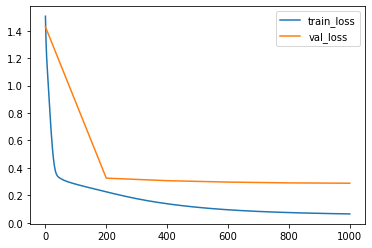

In [33]:
plt.plot(loss_LAE['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_LAE['val_loss'])
plt.legend(loss_LAE.keys())

##### Masked linear autoencoder (basic)

In [34]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_basic = M_LAE(prob, sample_dim, reduction_dim).to(device)

    params = list(net_MLAE_basic.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_basic = train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_basic'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.422879372868609 , val loss 1.3478038592219301
epoch:  200 , train loss:  0.2624811128744812 , val loss 0.33775154495890136
epoch:  400 , train loss:  0.1947093582111364 , val loss 0.3288392207256112
epoch:  600 , train loss:  0.15966365366310528 , val loss 0.3244177443130828
epoch:  800 , train loss:  0.14642537153644378 , val loss 0.32543768243681054
epoch:  1000 , train loss:  0.13640629220025344 , val loss 0.3208097783616776


100%|██████████| 250/250 [18:26<00:00,  4.43s/it]


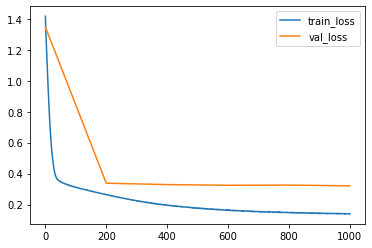

In [35]:
plt.plot(loss_MLAE_basic['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_basic['val_loss'])
plt.legend(loss_MLAE_basic.keys())

##### Masked linear autoencoder (probs)

In [36]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_probs = M_LAE(prob_list, sample_dim, reduction_dim, type='probs').to(device)

    params = list(net_MLAE_probs.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_probs = train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_probs'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.396071779212548 , val loss 1.3325267815930164
epoch:  200 , train loss:  0.2618252352191017 , val loss 0.3350629088684082
epoch:  400 , train loss:  0.1955622550859099 , val loss 0.3254639663595864
epoch:  600 , train loss:  0.16117131723282724 , val loss 0.3210512553473619
epoch:  800 , train loss:  0.14796330923868972 , val loss 0.32033199455036526
epoch:  1000 , train loss:  0.13733639807453402 , val loss 0.32429540828257036


100%|██████████| 250/250 [22:48<00:00,  5.47s/it]


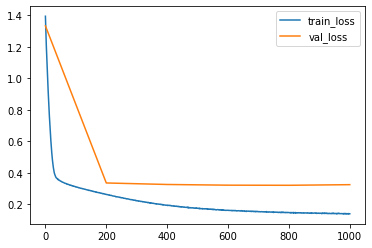

In [37]:
plt.plot(loss_MLAE_probs['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_probs['val_loss'])
plt.legend(loss_MLAE_probs.keys())

##### Masked linear autoencoder (patches)

In [38]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_patches = M_LAE(prob, sample_dim, reduction_dim, type='patches', patch_size=patch_size).to(device)

    params = list(net_MLAE_patches.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_patches = train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_patches'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.4577518503516946 , val loss 1.3916502124575092
epoch:  200 , train loss:  0.2641300063157936 , val loss 0.34604247374731
epoch:  400 , train loss:  0.1796490546600261 , val loss 0.3279411092014668
epoch:  600 , train loss:  0.1483403411841586 , val loss 0.32471255501376206
epoch:  800 , train loss:  0.1246947775755708 , val loss 0.31377413060773784
epoch:  1000 , train loss:  0.11568720876205218 , val loss 0.3119728711066851


100%|██████████| 250/250 [25:33<00:00,  6.13s/it]


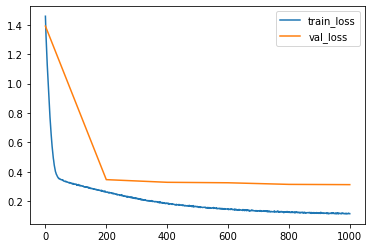

In [39]:
plt.plot(loss_MLAE_patches['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_patches['val_loss'])
plt.legend(loss_MLAE_patches.keys())

### Evaluation

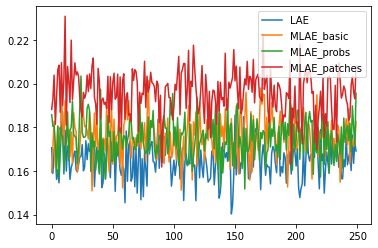

In [40]:
plt.plot(fe_loss_dict['LAE'])
plt.plot(fe_loss_dict['MLAE_basic'])
plt.plot(fe_loss_dict['MLAE_probs'])
plt.plot(fe_loss_dict['MLAE_patches'])
plt.legend(['LAE', 'MLAE_basic', 'MLAE_probs', 'MLAE_patches'])

In [41]:
fe_stats_dict = {'LAE': {'mean': statistics.mean(fe_loss_dict['LAE']), 'sd': statistics.stdev(fe_loss_dict['LAE'])},
                 'MLAE_basic': {'mean': statistics.mean(fe_loss_dict['MLAE_basic']), 'sd': statistics.stdev(fe_loss_dict['MLAE_basic'])},
                 'MLAE_probs': {'mean': statistics.mean(fe_loss_dict['MLAE_probs']), 'sd': statistics.stdev(fe_loss_dict['MLAE_probs'])},
                 'MLAE_patches': {'mean': statistics.mean(fe_loss_dict['MLAE_patches']), 'sd': statistics.stdev(fe_loss_dict['MLAE_patches'])}}
print(fe_stats_dict)

{'LAE': {'mean': 0.16505192134516541, 'sd': 0.008203782012058475}, 'MLAE_basic': {'mean': 0.1762410483406905, 'sd': 0.009330674668168018}, 'MLAE_probs': {'mean': 0.17501108317108932, 'sd': 0.009123475168440597}, 'MLAE_patches': {'mean': 0.19565433942856067, 'sd': 0.01027550482553792}}


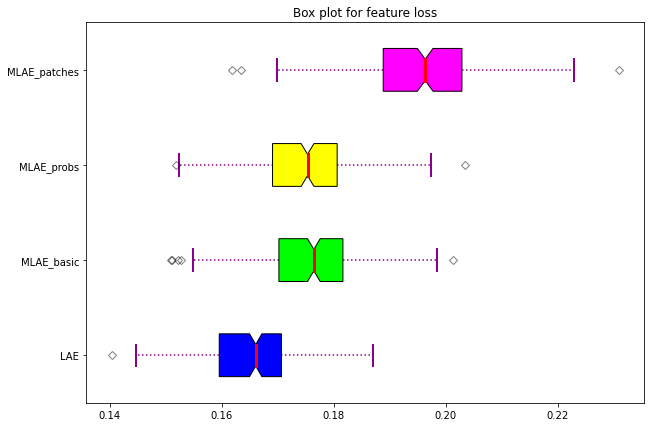

In [42]:
data = fe_loss_dict.values()
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(fe_loss_dict.keys())
 
# Adding title
plt.title("Box plot for feature loss")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()